In [7]:
import queue
import random
import torch
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.utils.data
from torch import optim
from torch import nn
from torch import distributions as dist

from core import *
from bandits import *

print(torch.__version__)


1.0.1.post2


In [0]:
use_cuda = torch.cuda.is_available()

In [0]:
CONTEXT_SIZE = 117 + 1
SAMPLE_COUNT = 2
NUM_ACTIONS = 2
AGENT_MEMORY_LEN = 4096

EDIBLE_REWARD = 5.0
POISONOUS_REWARD = -35.0

EDIBLE_CONSTANT = 1.0
POISONOUS_CONSTANT = -1.0

The environment sends the agent the features of a mushroom.

The agent can pick one of two actions:
1. eat
2. pass

If the agent picks pass, the regret is always 0.

If the agent picks eat:
1. if the mushroom is edible, the reward is always +5.0.
2. if the mushroom is poisonous, with prob 1/2 the reward is -35.0, with prob 1/2 the reward is +5.0

In [0]:
# Load the UCI Mushroom Dataset: 8124 datapoints, each with 22 categorical
# features and one label - edible/poisonous. The features are transformed to a
# one-hot encoding. 
# The missing values (marked with ?) are treated as a different class for now.

mushroom_dataset = pd.read_csv('mushrooms.csv')
train_labels = mushroom_dataset['class']
train_labels = train_labels.replace(['p', 'e'],
                                    [POISONOUS_CONSTANT, EDIBLE_CONSTANT])
train_features = pd.get_dummies(mushroom_dataset.drop(['class'], axis=1))

train_features = torch.tensor(train_features.values, dtype=torch.float)
train_labels = torch.tensor(train_labels.values)

trainset = torch.utils.data.TensorDataset(train_features, train_labels)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1,
                                          shuffle=True, num_workers=1)

The system is represented by two entities: an **agent** and an **environment**.  They interact in rounds, in the following manner:

1. The environment randomly selects a mushroom from the dataset and presents its features (the current context) to the agent.

2. The agent selects an action that it deems optimal given the context.

3. The environment computes the reward for the selected action and sends it back to the agent, which updates its predictions.

In [0]:
#@title Agent class definition (run from bandits.py)
class Agent(object):
  def __init__(self):
    # Previous 4096 interactions with the environment
    self.past_plays_context = []
    self.past_plays_action = []
    self.past_plays_reward = []
    self.value_estimates = None
    
    
  def collected_data_count(self):
    return len(self.past_plays_context)

  def select_action(self, context, logs):
    pass
  def update_variational_posterior(self, logs):
    pass
  def update_memory(self, context, action, reward):
    self.past_plays_context.append(context)
    self.past_plays_action.append(action)
    self.past_plays_reward.append(reward)
    if len(self.past_plays_context) == AGENT_MEMORY_LEN:
      self.past_plays_context = self.past_plays_context[1:]
      self.past_plays_action = self.past_plays_action[1:]
      self.past_plays_reward = self.past_plays_reward[1:]
    

class EGreedyNNAgent(Agent):
  def __init__(self, epsilon):
    super().__init__()
    self.epsilon = epsilon
    self.value_estimates =  nn.Sequential(
        torch.nn.Linear(CONTEXT_SIZE, 100),
        torch.nn.ReLU(),
        torch.nn.Linear(100, 100),
        torch.nn.ReLU(),
        torch.nn.Linear(100, 1),
    )
    
    self.loss_fn = nn.MSELoss()
    
    if use_cuda:
      self.value_estimates = self.value_estimates.cuda()
    
    self.optimizer = optim.Adam(self.value_estimates.parameters(), lr=1e-3,
                                eps=0.01)
    
    
  def select_action(self, context, logs=False):
    if random.random() < self.epsilon:
      return random.randint(0,NUM_ACTIONS-1)
    
    max_reward = POISONOUS_REWARD - 1
    argmax_action = -1
    for action in range(NUM_ACTIONS):
      estimated_reward = 0
      
        
      action_tensor = torch.tensor([[action]], dtype=torch.float)
        
      context_and_action = torch.cat(
          [context, action_tensor], dim=1)
        
      if use_cuda:
        context_and_action = context_and_action.cuda()
        
      estimated_reward = self.value_estimates(context_and_action)
      if logs:
        print('Action {} - predicted reward: {}'.format(
            action, estimated_reward))
      if estimated_reward > max_reward:
        max_reward = estimated_reward
        argmax_action = action
    return argmax_action

  
  def update_variational_posterior(self, logs=False):
    features = []
    for context, action in zip(iter(self.past_plays_context),
                               iter(self.past_plays_action)):
      
      action_tensor = torch.tensor([[action]], dtype=torch.float)
      
      features.append(torch.cat(
          [context, action_tensor], dim=1))
    features = torch.cat(features)
    
    rewards = torch.tensor(self.past_plays_reward, dtype=torch.float)

    past_plays_set = torch.utils.data.TensorDataset(features, rewards)
    past_plays_loader = torch.utils.data.DataLoader(
        past_plays_set, batch_size=64, shuffle=True, num_workers=1)
    
    avg_loss = 0
    
    for i, data in enumerate(past_plays_loader):
      inputs, labels = data
      if use_cuda:
        inputs = inputs.cuda()
        labels = labels.cuda()
      # zero the parameter gradients
      self.optimizer.zero_grad()

      # forward + backward + optimize
      
      loss = self.loss_fn(self.value_estimates(inputs), labels)

      loss.backward()
      self.optimizer.step()
     
      avg_loss += loss
      
    avg_loss /= len(past_plays_loader.dataset)
    
    if logs:
      print('{}. Loss: {}'.format(i, avg_loss))
    return avg_loss    
  
class BNNAgent(Agent):
  
  def __init__(self):
    super().__init__()
    # Neural net for estimating E[reward | context, action]
    self.value_estimates = BayesianNN(
        CONTEXT_SIZE, [100, 100, 1],
        [ActivationType.RELU, ActivationType.RELU, ActivationType.NONE])
    if use_cuda:
      self.value_estimates = self.value_estimates.cuda()
    
    self.optimizer = optim.Adam(self.value_estimates.parameters(), lr=1e-3,
                                   eps=0.1)
  

  
  def select_action(self, context, logs=False):
    self.value_estimates.train()
    max_reward = POISONOUS_REWARD - 1
    argmax_action = -1
    for action in range(NUM_ACTIONS):
      expected_reward = 0
      for i in range(SAMPLE_COUNT):
        
        action_tensor = torch.tensor([[action]], dtype=torch.float)
        
        context_and_action = torch.cat(
            [context, action_tensor], dim=1)
        
        if use_cuda:
          context_and_action = context_and_action.cuda()
        
        expected_reward += self.value_estimates(context_and_action)
      expected_reward /= SAMPLE_COUNT
      if logs:
        print('Action {} - predicted reward: {}'.format(
            action, expected_reward))
      if expected_reward > max_reward:
        max_reward = expected_reward
        argmax_action = action
    return argmax_action
  

  def update_variational_posterior(self, logs=False):
    features = []
    for context, action in zip(iter(self.past_plays_context),
                               iter(self.past_plays_action)):
      
      action_tensor = torch.tensor([[action]], dtype=torch.float)
      
      features.append(torch.cat(
          [context, action_tensor], dim=1))
    features = torch.cat(features)
    
    rewards = torch.tensor(self.past_plays_reward, dtype=torch.float)

    past_plays_set = torch.utils.data.TensorDataset(features, rewards)
    past_plays_loader = torch.utils.data.DataLoader(
        past_plays_set, batch_size=64, shuffle=True, num_workers=1)
    
    avg_loss = 0
    
    for i, data in enumerate(past_plays_loader):
      inputs, labels = data
      if use_cuda:
        inputs = inputs.cuda()
        labels = labels.cuda()
      # zero the parameter gradients
      self.optimizer.zero_grad()

      # forward + backward + optimize
      loss, _, _ = self.value_estimates.cost_function(
          inputs, labels, num_samples=2, num_batches=len(past_plays_loader))
      loss.backward()
      self.optimizer.step()
     
      avg_loss += loss
      
    avg_loss /= len(past_plays_loader.dataset)
    
    if logs:
      print('{}. Loss: {}'.format(i, avg_loss))
    return avg_loss    
      

In [0]:
#@title Environment class definition (run from bandits.py)
class Environment(object):
  
  def __init__(self, agent, dataloader):
    self.agent = agent
    self.dataloader = dataloader
    self.cumulative_regret = 0
  
  def play_round(self, logs=False):
    
    # Get the features and label of a random mushroom
    context, mushroom_type = next(iter(self.dataloader))
    
    # Set GPU tensors; context doesn't get updated because it is fed into
    # the dataloader of the agent
    if use_cuda:
      mushroom_type = mushroom_type.cuda()
    
    # Determine the 'eat' reward and the optimal reward for the current mushroom
    if mushroom_type == EDIBLE_CONSTANT:
      eat_reward = EDIBLE_REWARD
      optimal_reward = EDIBLE_REWARD
      mushroom_string = 'edible'
    else: #poisonous
      optimal_reward = 0.0
      mushroom_string = 'poisonous'
      random_draw = random.random()
      if random_draw > 0.5:
        eat_reward = EDIBLE_REWARD
      else:
        eat_reward = POISONOUS_REWARD
        
    # Present the context to the agent and get the the agent's action of choice
    selected_action = self.agent.select_action(context, logs)
    
    # Determine the reward for the agent's action and the regret
    if selected_action == 0: #not eat
      action_string = 'pass'
      reward = 0
    else: #eat
      action_string = 'eat'
      reward = eat_reward
    self.cumulative_regret += max(optimal_reward - reward, 0) 
    
    if logs:
      print('The mushroom was {}. The agent chose {} and got a reward of {}.'.format(mushroom_string, action_string, reward))
      print('Cumulative regret is {}'.format(self.cumulative_regret))
      
    # Send the reward information back to the agent for logging and variational
    # posterior update
    self.agent.update_memory(context, selected_action, reward)
    loss = self.agent.update_variational_posterior(logs)
    
    return loss
    

In [0]:
# Tuned paramaters for bnn and eg agents

LEARNING_RATE = 0.001
EPSILON = 0.001
PI = 0.75
SIGMA1 = math.exp(-2)
SIGMA2 = math.exp(-7)

99
The mushroom was poisonous. The agent chose pass and got a reward of 0.
Cumulative regret is 365.0
1. Loss: 0.5068902373313904
Action 0 - predicted reward: tensor([[-1.4390]], device='cuda:0', grad_fn=<DivBackward0>)
Action 1 - predicted reward: tensor([[1.0724]], device='cuda:0', grad_fn=<DivBackward0>)
The mushroom was poisonous. The agent chose eat and got a reward of -35.0.
Cumulative regret is 565.0
1. Loss: 191814.59375


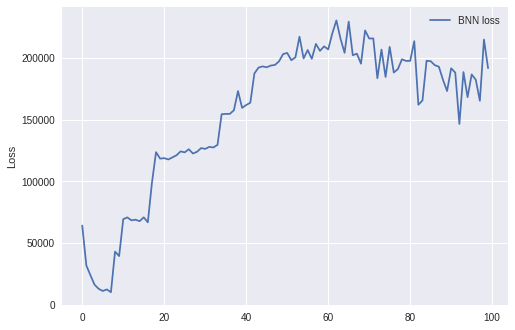

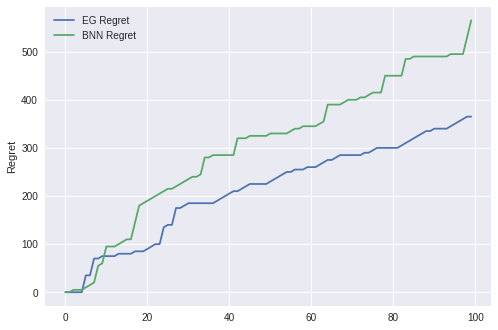

199
Action 0 - predicted reward: tensor([[-1.5426]], device='cuda:0', grad_fn=<AddmmBackward>)
Action 1 - predicted reward: tensor([[-7.4881]], device='cuda:0', grad_fn=<AddmmBackward>)
The mushroom was poisonous. The agent chose pass and got a reward of 0.
Cumulative regret is 605.0
3. Loss: 0.15730582177639008
Action 0 - predicted reward: tensor([[-1.7284]], device='cuda:0', grad_fn=<DivBackward0>)
Action 1 - predicted reward: tensor([[-1.5811]], device='cuda:0', grad_fn=<DivBackward0>)
The mushroom was poisonous. The agent chose eat and got a reward of -35.0.
Cumulative regret is 990.0
3. Loss: 223687.921875


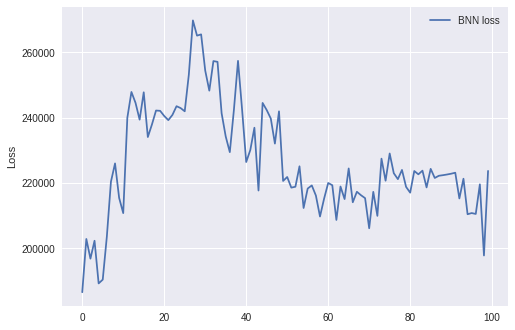

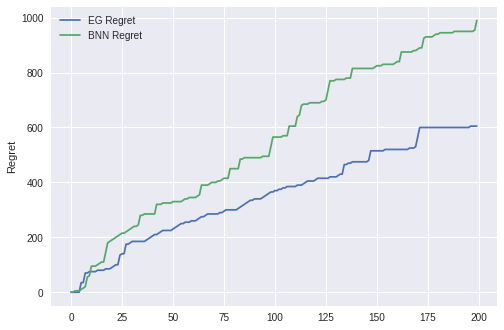

299
Action 0 - predicted reward: tensor([[-0.8342]], device='cuda:0', grad_fn=<AddmmBackward>)
Action 1 - predicted reward: tensor([[2.9429]], device='cuda:0', grad_fn=<AddmmBackward>)
The mushroom was edible. The agent chose eat and got a reward of 5.0.
Cumulative regret is 745.0
4. Loss: 0.01297764666378498
Action 0 - predicted reward: tensor([[-2.2176]], device='cuda:0', grad_fn=<DivBackward0>)
Action 1 - predicted reward: tensor([[-1.4463]], device='cuda:0', grad_fn=<DivBackward0>)
The mushroom was poisonous. The agent chose eat and got a reward of -35.0.
Cumulative regret is 1465.0
4. Loss: 218408.28125


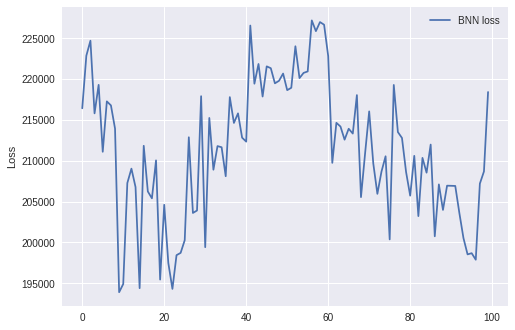

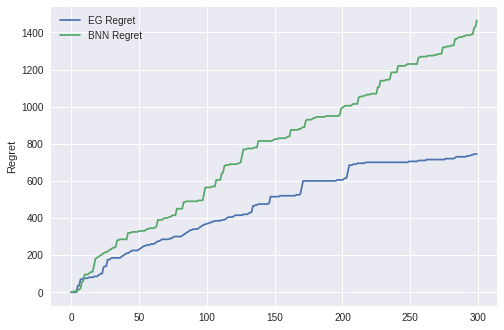

399
Action 0 - predicted reward: tensor([[1.2402]], device='cuda:0', grad_fn=<AddmmBackward>)
Action 1 - predicted reward: tensor([[5.5613]], device='cuda:0', grad_fn=<AddmmBackward>)
The mushroom was edible. The agent chose eat and got a reward of 5.0.
Cumulative regret is 915.0
6. Loss: 0.0246376171708107
Action 0 - predicted reward: tensor([[-1.5246]], device='cuda:0', grad_fn=<DivBackward0>)
Action 1 - predicted reward: tensor([[-2.7714]], device='cuda:0', grad_fn=<DivBackward0>)
The mushroom was poisonous. The agent chose pass and got a reward of 0.
Cumulative regret is 1865.0
6. Loss: 195662.671875


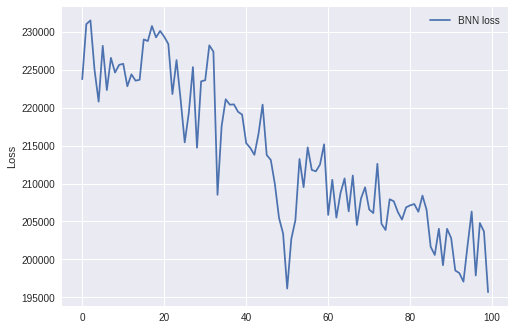

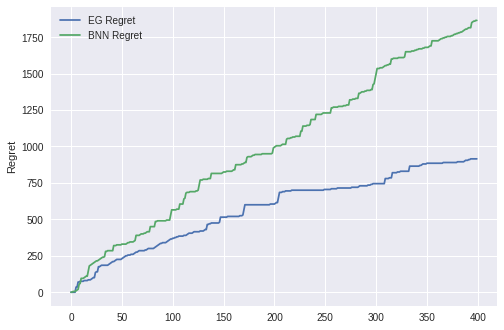

499
Action 0 - predicted reward: tensor([[-0.8040]], device='cuda:0', grad_fn=<AddmmBackward>)
Action 1 - predicted reward: tensor([[-25.0256]], device='cuda:0', grad_fn=<AddmmBackward>)
The mushroom was poisonous. The agent chose pass and got a reward of 0.
Cumulative regret is 1040.0
7. Loss: 0.026926450431346893
Action 0 - predicted reward: tensor([[-1.4856]], device='cuda:0', grad_fn=<DivBackward0>)
Action 1 - predicted reward: tensor([[-2.0477]], device='cuda:0', grad_fn=<DivBackward0>)
The mushroom was edible. The agent chose pass and got a reward of 0.
Cumulative regret is 2435.0
7. Loss: 211742.53125


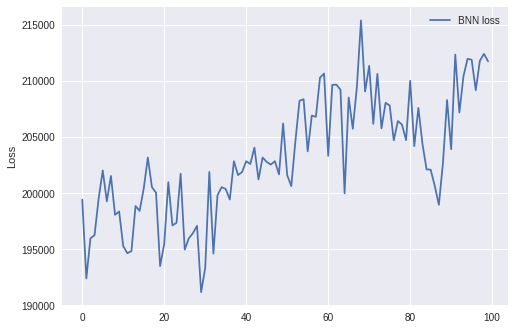

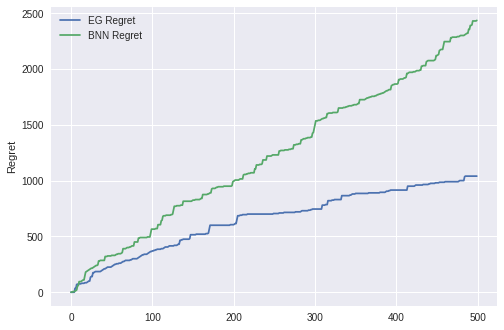

599
Action 0 - predicted reward: tensor([[-0.9130]], device='cuda:0', grad_fn=<AddmmBackward>)
Action 1 - predicted reward: tensor([[4.9118]], device='cuda:0', grad_fn=<AddmmBackward>)
The mushroom was edible. The agent chose eat and got a reward of 5.0.
Cumulative regret is 1075.0
9. Loss: 0.00833128672093153
Action 0 - predicted reward: tensor([[-1.7360]], device='cuda:0', grad_fn=<DivBackward0>)
Action 1 - predicted reward: tensor([[-1.7130]], device='cuda:0', grad_fn=<DivBackward0>)
The mushroom was edible. The agent chose eat and got a reward of 5.0.
Cumulative regret is 2995.0
9. Loss: 211032.65625


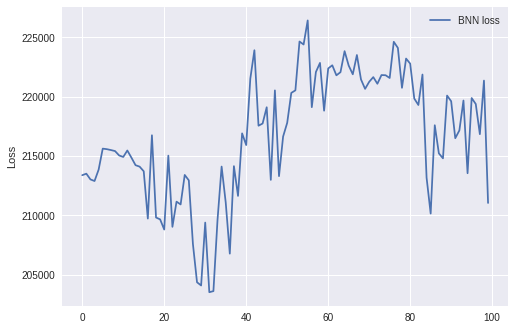

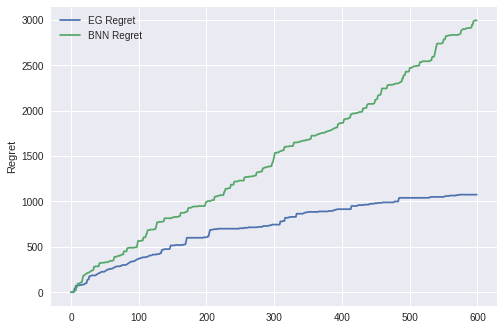

699
Action 0 - predicted reward: tensor([[-0.1390]], device='cuda:0', grad_fn=<AddmmBackward>)
Action 1 - predicted reward: tensor([[-27.3279]], device='cuda:0', grad_fn=<AddmmBackward>)
The mushroom was poisonous. The agent chose pass and got a reward of 0.
Cumulative regret is 1170.0
10. Loss: 0.014349263161420822
Action 0 - predicted reward: tensor([[-1.8400]], device='cuda:0', grad_fn=<DivBackward0>)
Action 1 - predicted reward: tensor([[-1.9090]], device='cuda:0', grad_fn=<DivBackward0>)
The mushroom was poisonous. The agent chose pass and got a reward of 0.
Cumulative regret is 3375.0
10. Loss: 210578.953125


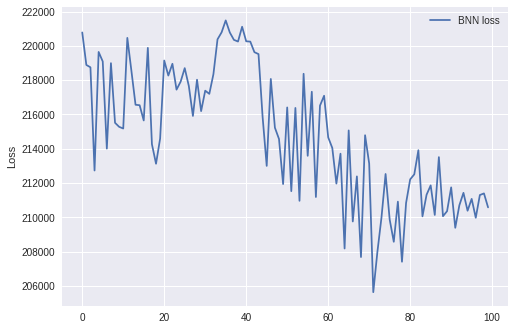

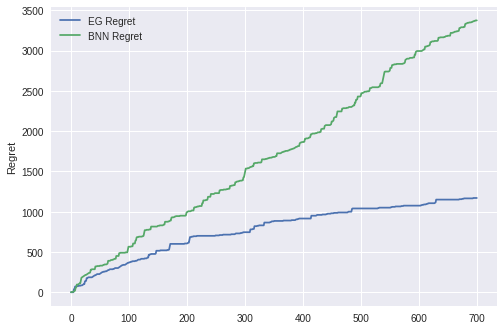

799
Action 0 - predicted reward: tensor([[-0.7381]], device='cuda:0', grad_fn=<AddmmBackward>)
Action 1 - predicted reward: tensor([[-9.3569]], device='cuda:0', grad_fn=<AddmmBackward>)
The mushroom was poisonous. The agent chose pass and got a reward of 0.
Cumulative regret is 1200.0
12. Loss: 0.005859034601598978
Action 0 - predicted reward: tensor([[-1.5582]], device='cuda:0', grad_fn=<DivBackward0>)
Action 1 - predicted reward: tensor([[-1.6711]], device='cuda:0', grad_fn=<DivBackward0>)
The mushroom was edible. The agent chose pass and got a reward of 0.
Cumulative regret is 3880.0
12. Loss: 208634.609375


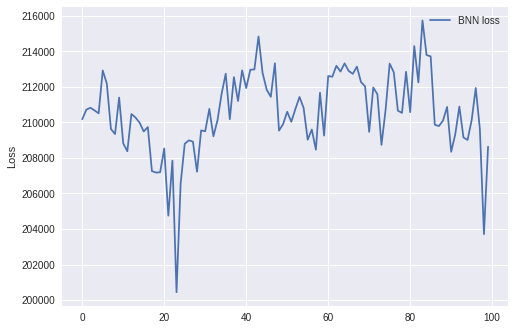

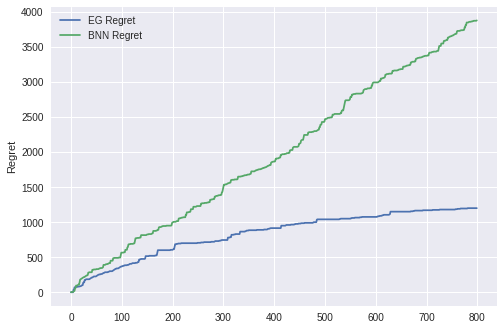

899
Action 0 - predicted reward: tensor([[-1.1183]], device='cuda:0', grad_fn=<AddmmBackward>)
Action 1 - predicted reward: tensor([[-8.5635]], device='cuda:0', grad_fn=<AddmmBackward>)
The mushroom was poisonous. The agent chose pass and got a reward of 0.
Cumulative regret is 1225.0
14. Loss: 0.005823258776217699
Action 0 - predicted reward: tensor([[-1.4168]], device='cuda:0', grad_fn=<DivBackward0>)
Action 1 - predicted reward: tensor([[-1.2868]], device='cuda:0', grad_fn=<DivBackward0>)
The mushroom was edible. The agent chose eat and got a reward of 5.0.
Cumulative regret is 4110.0
14. Loss: 201286.53125


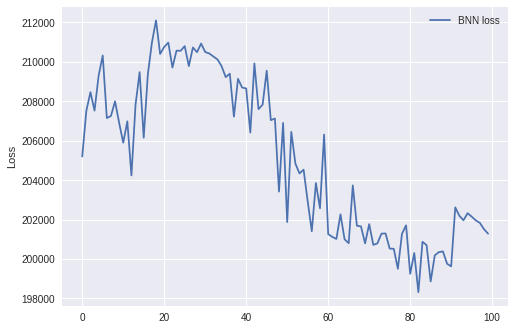

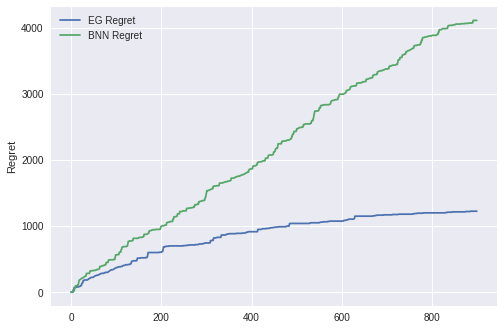

999
Action 0 - predicted reward: tensor([[-2.3613]], device='cuda:0', grad_fn=<AddmmBackward>)
Action 1 - predicted reward: tensor([[-30.2622]], device='cuda:0', grad_fn=<AddmmBackward>)
The mushroom was edible. The agent chose pass and got a reward of 0.
Cumulative regret is 1270.0
15. Loss: 0.0008931352640502155
Action 0 - predicted reward: tensor([[-1.4430]], device='cuda:0', grad_fn=<DivBackward0>)
Action 1 - predicted reward: tensor([[-1.5645]], device='cuda:0', grad_fn=<DivBackward0>)
The mushroom was edible. The agent chose pass and got a reward of 0.
Cumulative regret is 4510.0
15. Loss: 201239.171875


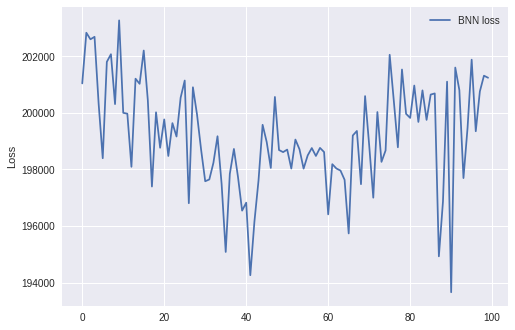

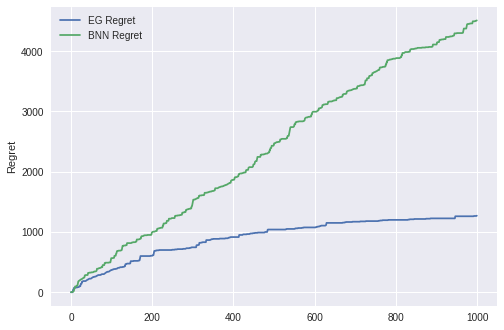

1099
Action 0 - predicted reward: tensor([[1.0267]], device='cuda:0', grad_fn=<AddmmBackward>)
Action 1 - predicted reward: tensor([[-14.5876]], device='cuda:0', grad_fn=<AddmmBackward>)
The mushroom was poisonous. The agent chose pass and got a reward of 0.
Cumulative regret is 1390.0
17. Loss: 0.002795690903440118
Action 0 - predicted reward: tensor([[-1.2481]], device='cuda:0', grad_fn=<DivBackward0>)
Action 1 - predicted reward: tensor([[-1.1605]], device='cuda:0', grad_fn=<DivBackward0>)
The mushroom was poisonous. The agent chose eat and got a reward of -35.0.
Cumulative regret is 4975.0
17. Loss: 200849.0


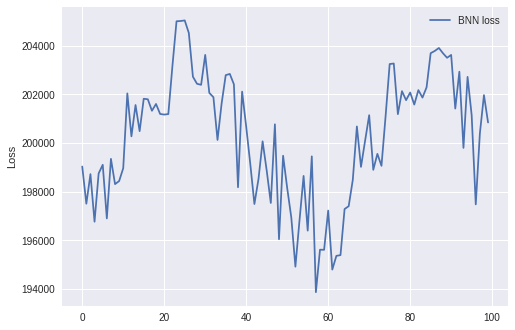

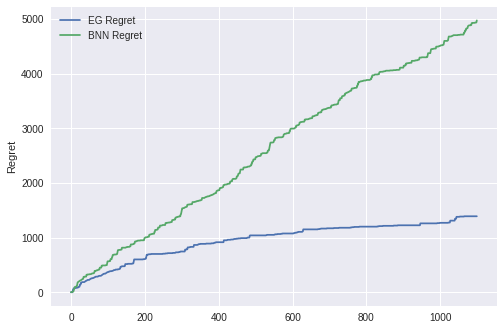

1199
Action 0 - predicted reward: tensor([[0.2480]], device='cuda:0', grad_fn=<AddmmBackward>)
Action 1 - predicted reward: tensor([[-23.8719]], device='cuda:0', grad_fn=<AddmmBackward>)
The mushroom was poisonous. The agent chose pass and got a reward of 0.
Cumulative regret is 1480.0
18. Loss: 0.002030110452324152
Action 0 - predicted reward: tensor([[-1.1655]], device='cuda:0', grad_fn=<DivBackward0>)
Action 1 - predicted reward: tensor([[-1.1423]], device='cuda:0', grad_fn=<DivBackward0>)
The mushroom was edible. The agent chose eat and got a reward of 5.0.
Cumulative regret is 5165.0
18. Loss: 191173.5


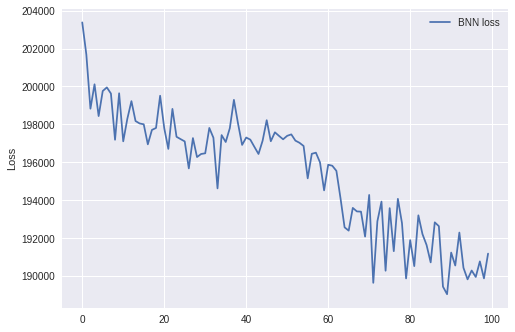

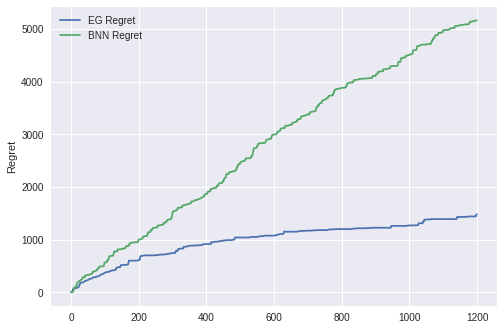

1299
Action 0 - predicted reward: tensor([[-0.9763]], device='cuda:0', grad_fn=<AddmmBackward>)
Action 1 - predicted reward: tensor([[-20.8635]], device='cuda:0', grad_fn=<AddmmBackward>)
The mushroom was poisonous. The agent chose pass and got a reward of 0.
Cumulative regret is 1565.0
20. Loss: 0.0022589005529880524
Action 0 - predicted reward: tensor([[-1.3263]], device='cuda:0', grad_fn=<DivBackward0>)
Action 1 - predicted reward: tensor([[-1.2832]], device='cuda:0', grad_fn=<DivBackward0>)
The mushroom was poisonous. The agent chose eat and got a reward of 5.0.
Cumulative regret is 5475.0
20. Loss: 185813.40625


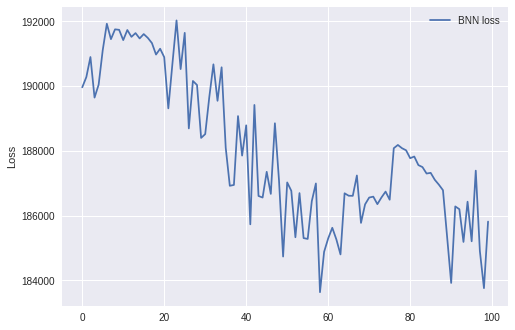

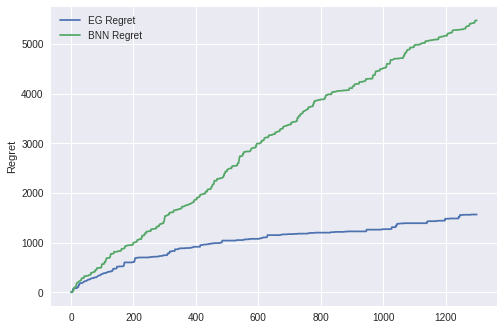

1399
Action 0 - predicted reward: tensor([[-0.0398]], device='cuda:0', grad_fn=<AddmmBackward>)
Action 1 - predicted reward: tensor([[-39.9465]], device='cuda:0', grad_fn=<AddmmBackward>)
The mushroom was poisonous. The agent chose pass and got a reward of 0.
Cumulative regret is 1610.0
21. Loss: 0.012973188422620296
Action 0 - predicted reward: tensor([[-0.9506]], device='cuda:0', grad_fn=<DivBackward0>)
Action 1 - predicted reward: tensor([[-0.9817]], device='cuda:0', grad_fn=<DivBackward0>)
The mushroom was poisonous. The agent chose pass and got a reward of 0.
Cumulative regret is 5635.0
21. Loss: 176470.234375


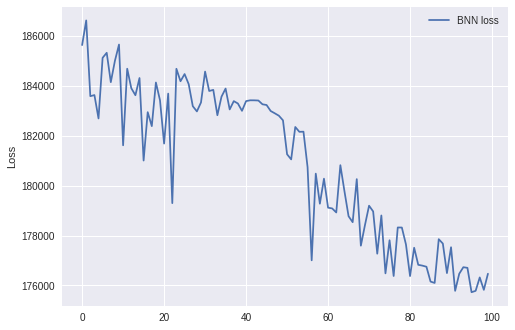

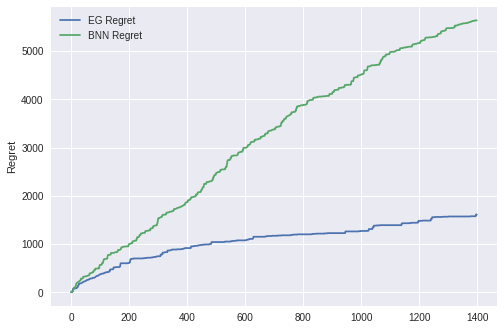

1499
Action 0 - predicted reward: tensor([[-0.0992]], device='cuda:0', grad_fn=<AddmmBackward>)
Action 1 - predicted reward: tensor([[-15.2311]], device='cuda:0', grad_fn=<AddmmBackward>)
The mushroom was poisonous. The agent chose pass and got a reward of 0.
Cumulative regret is 1685.0
23. Loss: 0.0005823556566610932
Action 0 - predicted reward: tensor([[-0.8267]], device='cuda:0', grad_fn=<DivBackward0>)
Action 1 - predicted reward: tensor([[-0.8269]], device='cuda:0', grad_fn=<DivBackward0>)
The mushroom was edible. The agent chose pass and got a reward of 0.
Cumulative regret is 5860.0
23. Loss: 167480.921875


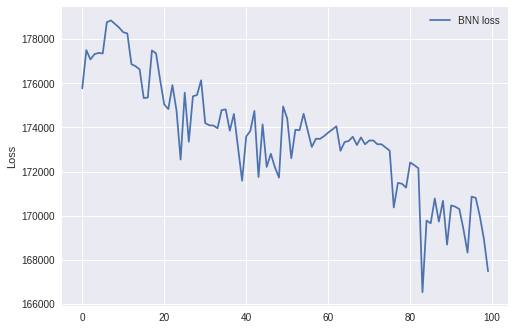

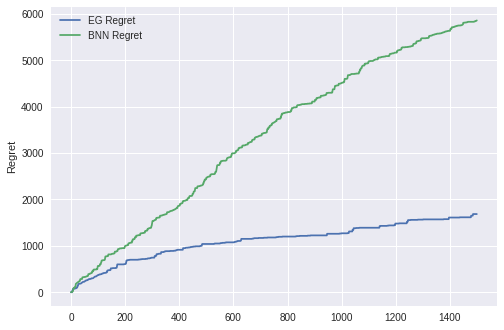

1599
Action 0 - predicted reward: tensor([[-0.8393]], device='cuda:0', grad_fn=<AddmmBackward>)
Action 1 - predicted reward: tensor([[4.6201]], device='cuda:0', grad_fn=<AddmmBackward>)
The mushroom was edible. The agent chose eat and got a reward of 5.0.
Cumulative regret is 1730.0
24. Loss: 0.005766311660408974
Action 0 - predicted reward: tensor([[-0.7864]], device='cuda:0', grad_fn=<DivBackward0>)
Action 1 - predicted reward: tensor([[-0.9651]], device='cuda:0', grad_fn=<DivBackward0>)
The mushroom was poisonous. The agent chose pass and got a reward of 0.
Cumulative regret is 6145.0
24. Loss: 165976.953125


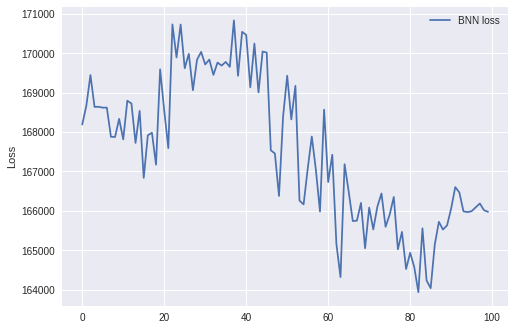

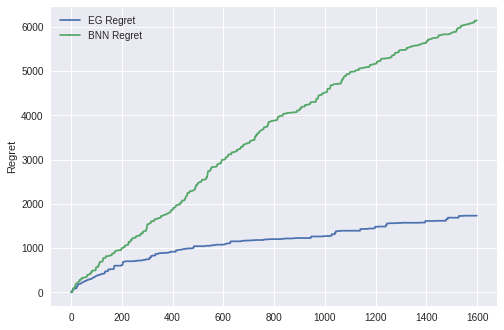

1699
Action 0 - predicted reward: tensor([[-2.1263]], device='cuda:0', grad_fn=<AddmmBackward>)
Action 1 - predicted reward: tensor([[4.4087]], device='cuda:0', grad_fn=<AddmmBackward>)
The mushroom was edible. The agent chose eat and got a reward of 5.0.
Cumulative regret is 1910.0
26. Loss: 0.015539941377937794
Action 0 - predicted reward: tensor([[-0.6584]], device='cuda:0', grad_fn=<DivBackward0>)
Action 1 - predicted reward: tensor([[-0.6394]], device='cuda:0', grad_fn=<DivBackward0>)
The mushroom was edible. The agent chose eat and got a reward of 5.0.
Cumulative regret is 6330.0
26. Loss: 159774.171875


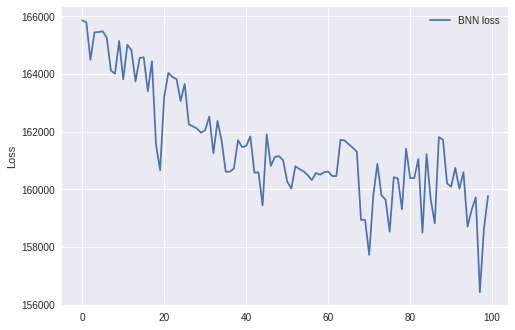

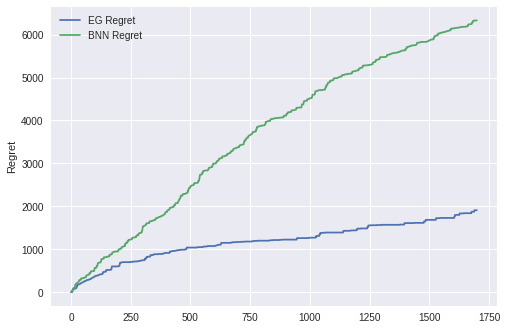

1799
Action 0 - predicted reward: tensor([[0.0537]], device='cuda:0', grad_fn=<AddmmBackward>)
Action 1 - predicted reward: tensor([[-13.9551]], device='cuda:0', grad_fn=<AddmmBackward>)
The mushroom was poisonous. The agent chose pass and got a reward of 0.
Cumulative regret is 2025.0
28. Loss: 0.009202299639582634
Action 0 - predicted reward: tensor([[-0.7169]], device='cuda:0', grad_fn=<DivBackward0>)
Action 1 - predicted reward: tensor([[-0.6701]], device='cuda:0', grad_fn=<DivBackward0>)
The mushroom was edible. The agent chose eat and got a reward of 5.0.
Cumulative regret is 6685.0
28. Loss: 160835.84375


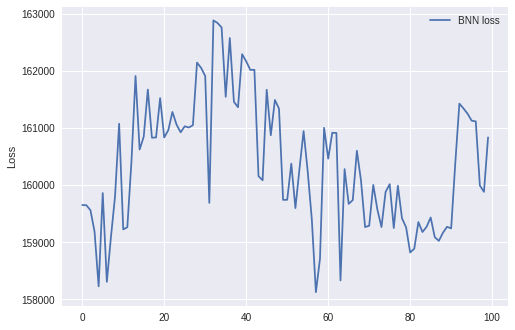

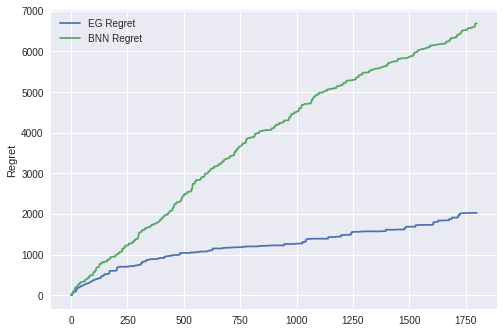

1899
Action 0 - predicted reward: tensor([[0.0654]], device='cuda:0', grad_fn=<AddmmBackward>)
Action 1 - predicted reward: tensor([[-34.4139]], device='cuda:0', grad_fn=<AddmmBackward>)
The mushroom was poisonous. The agent chose pass and got a reward of 0.
Cumulative regret is 2140.0
29. Loss: 0.0070602623745799065
Action 0 - predicted reward: tensor([[-0.7504]], device='cuda:0', grad_fn=<DivBackward0>)
Action 1 - predicted reward: tensor([[-0.7467]], device='cuda:0', grad_fn=<DivBackward0>)
The mushroom was poisonous. The agent chose eat and got a reward of -35.0.
Cumulative regret is 6935.0
29. Loss: 157662.515625


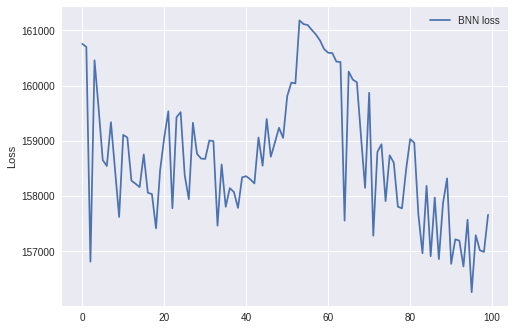

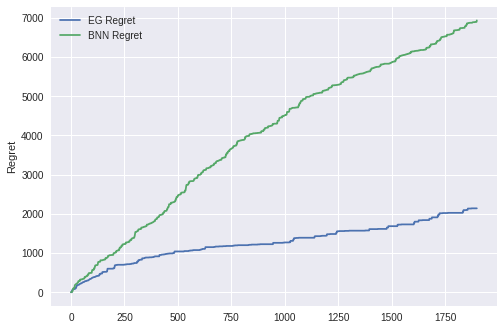

1999
Action 0 - predicted reward: tensor([[-0.0063]], device='cuda:0', grad_fn=<AddmmBackward>)
Action 1 - predicted reward: tensor([[5.3058]], device='cuda:0', grad_fn=<AddmmBackward>)
The mushroom was edible. The agent chose eat and got a reward of 5.0.
Cumulative regret is 2220.0
31. Loss: 0.011728893034160137
Action 0 - predicted reward: tensor([[-0.7138]], device='cuda:0', grad_fn=<DivBackward0>)
Action 1 - predicted reward: tensor([[-0.7618]], device='cuda:0', grad_fn=<DivBackward0>)
The mushroom was poisonous. The agent chose pass and got a reward of 0.
Cumulative regret is 7200.0
31. Loss: 155090.21875


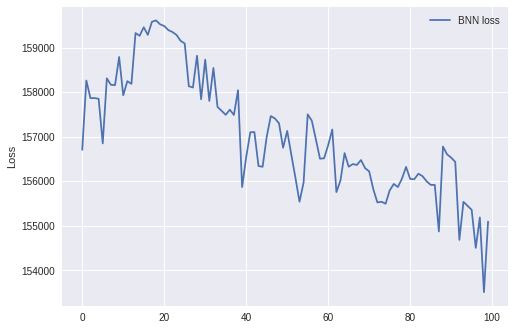

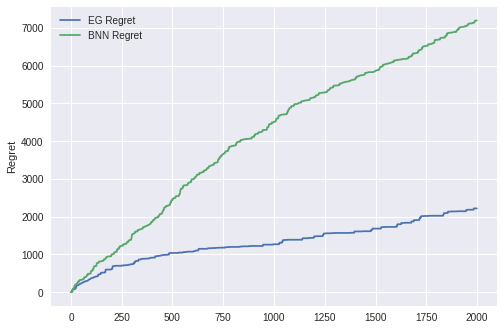

2099
Action 0 - predicted reward: tensor([[-0.2777]], device='cuda:0', grad_fn=<AddmmBackward>)
Action 1 - predicted reward: tensor([[-15.2664]], device='cuda:0', grad_fn=<AddmmBackward>)
The mushroom was poisonous. The agent chose pass and got a reward of 0.
Cumulative regret is 2330.0
32. Loss: 0.006857984699308872
Action 0 - predicted reward: tensor([[-0.6221]], device='cuda:0', grad_fn=<DivBackward0>)
Action 1 - predicted reward: tensor([[-0.5926]], device='cuda:0', grad_fn=<DivBackward0>)
The mushroom was edible. The agent chose eat and got a reward of 5.0.
Cumulative regret is 7460.0
32. Loss: 152967.625


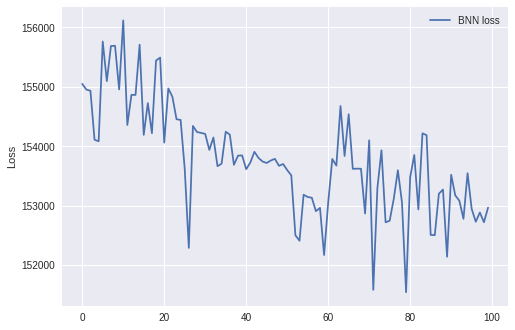

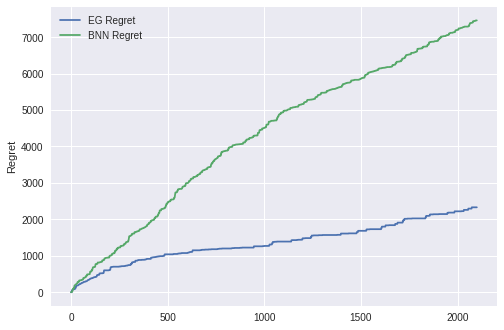

2199
Action 0 - predicted reward: tensor([[-0.0820]], device='cuda:0', grad_fn=<AddmmBackward>)
Action 1 - predicted reward: tensor([[5.3751]], device='cuda:0', grad_fn=<AddmmBackward>)
The mushroom was poisonous. The agent chose eat and got a reward of -35.0.
Cumulative regret is 2445.0
34. Loss: 0.02074841782450676
Action 0 - predicted reward: tensor([[-0.5412]], device='cuda:0', grad_fn=<DivBackward0>)
Action 1 - predicted reward: tensor([[-0.5129]], device='cuda:0', grad_fn=<DivBackward0>)
The mushroom was edible. The agent chose eat and got a reward of 5.0.
Cumulative regret is 7665.0
34. Loss: 148329.671875


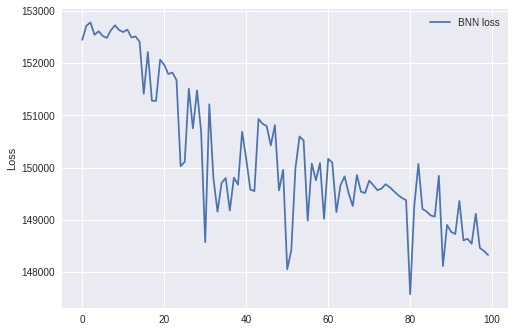

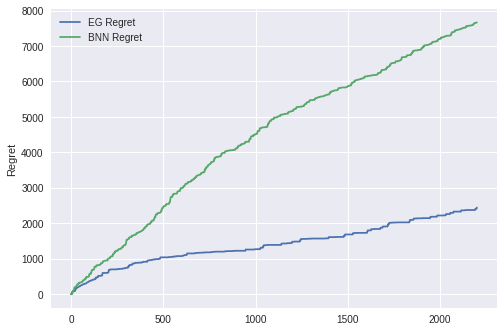

2299
Action 0 - predicted reward: tensor([[-0.2361]], device='cuda:0', grad_fn=<AddmmBackward>)
Action 1 - predicted reward: tensor([[4.8211]], device='cuda:0', grad_fn=<AddmmBackward>)
The mushroom was edible. The agent chose eat and got a reward of 5.0.
Cumulative regret is 2700.0
35. Loss: 0.01853582262992859
Action 0 - predicted reward: tensor([[-0.4400]], device='cuda:0', grad_fn=<DivBackward0>)
Action 1 - predicted reward: tensor([[-0.4360]], device='cuda:0', grad_fn=<DivBackward0>)
The mushroom was edible. The agent chose eat and got a reward of 5.0.
Cumulative regret is 7865.0
35. Loss: 144822.265625


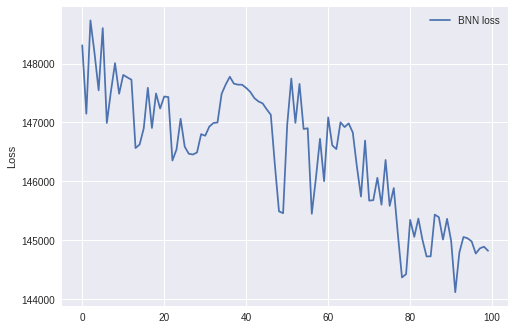

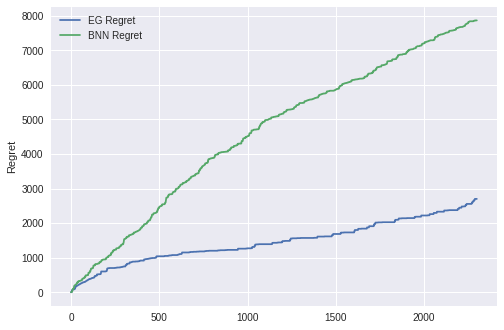

2399
Action 0 - predicted reward: tensor([[-0.1274]], device='cuda:0', grad_fn=<AddmmBackward>)
Action 1 - predicted reward: tensor([[-35.8761]], device='cuda:0', grad_fn=<AddmmBackward>)
The mushroom was poisonous. The agent chose pass and got a reward of 0.
Cumulative regret is 2805.0
37. Loss: 0.019698038697242737
Action 0 - predicted reward: tensor([[-0.4734]], device='cuda:0', grad_fn=<DivBackward0>)
Action 1 - predicted reward: tensor([[-0.4985]], device='cuda:0', grad_fn=<DivBackward0>)
The mushroom was poisonous. The agent chose pass and got a reward of 0.
Cumulative regret is 8120.0
37. Loss: 143034.625


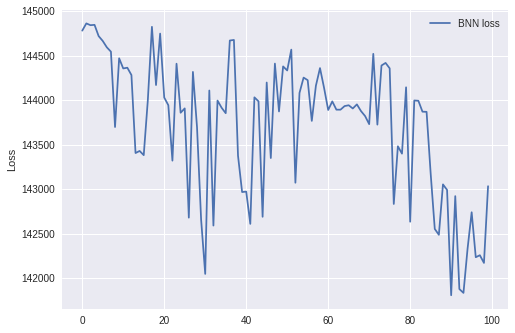

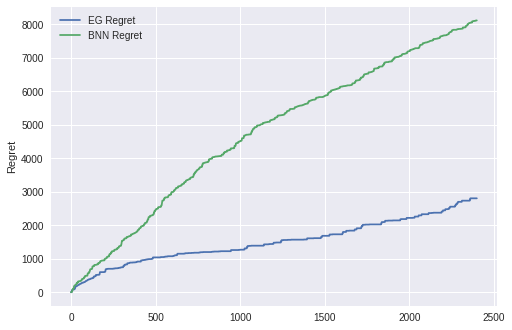

2499
Action 0 - predicted reward: tensor([[-0.1659]], device='cuda:0', grad_fn=<AddmmBackward>)
Action 1 - predicted reward: tensor([[-12.8071]], device='cuda:0', grad_fn=<AddmmBackward>)
The mushroom was poisonous. The agent chose pass and got a reward of 0.
Cumulative regret is 2960.0
39. Loss: 0.023345408961176872
Action 0 - predicted reward: tensor([[-0.3796]], device='cuda:0', grad_fn=<DivBackward0>)
Action 1 - predicted reward: tensor([[-0.3482]], device='cuda:0', grad_fn=<DivBackward0>)
The mushroom was edible. The agent chose eat and got a reward of 5.0.
Cumulative regret is 8200.0
39. Loss: 137316.1875


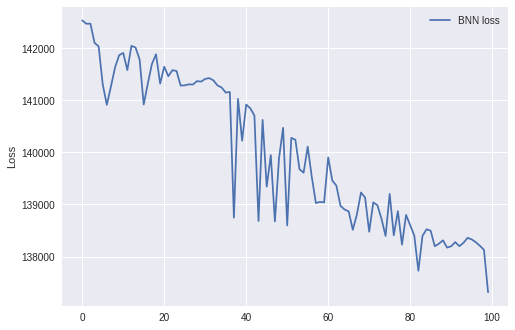

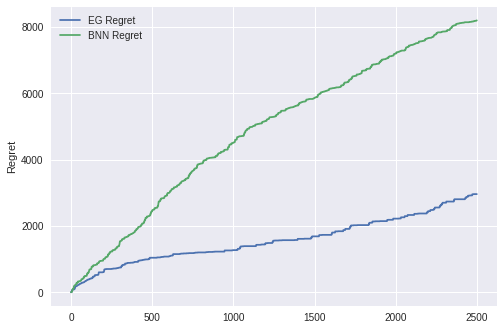

In [0]:
optimizer_constructor = torch.optim.Adam
optimizer_params = {'lr': LEARNING_RATE} #, 'eps': EPSILON,}
prior_params = {'pi': PI, 'sigma1': SIGMA1, 'sigma2': SIGMA2}
      
bnn_agent = BNNAgent(optimizer_constructor=optimizer_constructor,
                     optim_params=optimizer_params,
                     prior_params=prior_params)
bnn_env = Environment(bnn_agent, trainloader)

eg_agent = EGreedyNNAgent(epsilon=.05, 
                          optimizer_constructor=optimizer_constructor,
                          optim_params=optimizer_params)
eg_env = Environment(eg_agent, copy.deepcopy(trainloader))

eg_loss = []  # Loss in last 100
eg_regret = []
bnn_loss = []
bnn_regret = []


for i in range(100000):
  if i == AGENT_MEMORY_LEN:
    print('Started training')
  if (i+1) % 100 == 0:
    print(i)
    eg_loss.append(eg_env.play_round(logs=True))
    eg_regret.append(eg_env.cumulative_regret)
    bnn_loss.append(bnn_env.play_round(logs=True))
    bnn_regret.append(bnn_env.cumulative_regret)
    
#     plt.plot(np.array(eg_loss), label='EG loss')
    plt.plot(np.array(bnn_loss), label='BNN loss')
    plt.legend()
    plt.ylabel('Loss')
    plt.show()
    
    plt.plot(np.array(eg_regret), label='EG Regret')
    plt.plot(np.array(bnn_regret), label='BNN Regret')
    plt.legend()
    plt.ylabel('Regret')
    plt.show()
    bnn_loss = []
    eg_loss = []
  else:
    eg_loss.append(eg_env.play_round())
    bnn_loss.append(bnn_env.play_round())
   
    eg_regret.append(eg_env.cumulative_regret)
    bnn_regret.append(bnn_env.cumulative_regret)
